In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import *

In [2]:
%matplotlib inline

### Access data ###

The first step was to access the Internet Advertisements Data Set from the UCL ML repo: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements

The internet advertisement data folder contains two files - one which contains the data set and one which contains header names. These two  need to be combined - providing the foundation for the features used predict whether an image is an advertisement ("ad") or not ("nonad")

First, we take the ad data set from the url and and load it into a pandas dataframe

In [3]:
#assign url as string where we will pull data from
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.data"

#pull down the csv file into a pandas dataframe
ad_df = pd.read_csv(url, header=None, dtype=None)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To get a quick view of the data, we'll use .head() function to preview the first 5 rows of data

In [4]:
ad_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Next, we need to get meaningful column headers since as you can see above our columns are labelled 0-1558.

This time, after we assign the url to a variable, we're going to use the request.get() function to pull non CSV data??? and store the url content as a requests object. As a requests object we can then pull out information from the scraped html using BeatifulSoup package.

In [5]:
#assign url where we will pull data from for column names
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.names"

#use requests to get url and store information as requests object
response = requests.get(url)

# use BeautifulSoup on content object to pull out relevant content
#lxml = type of html format we are working with
#.text = Get all the child strings and return concatenated using the given separator
#.split('\n') = given separator
soup = BeautifulSoup(response.content, "lxml").text.split('\n')

In [6]:
#print(soup)

To easily view and clean the scraped data we'll create a single column dataframe with a name attribute 

In [7]:
ad_names = pd.DataFrame({'header':soup})
print (ad_names)

                                                 header
0     | "w:\c4.5\alladA" names file -- automatically...
1                                                      
2                                  ad, nonad | classes.
3                                                      
4                                   height: continuous.
5                                    width: continuous.
6                                   aratio: continuous.
7                                           local: 0,1.
8                         | 457 features from url terms
9                              url*images+buttons: 0,1.
10                             url*likesbooks.com: 0,1.
11                              url*www.slake.com: 0,1.
12                             url*hydrogeologist: 0,1.
13                                        url*oso: 0,1.
14                                      url*media: 0,1.
15                               url*peace+images: 0,1.
16                                  url*blipvert

### Data Prep

As we can see above, the header values have a number of issues we need to clean up, including: 1) feature terms - we know from the data set description we have 5 groups of feature terms - url, origurl, ancurl, alt, and caption and each of these is mentioned in the data set and need to be removed as they won't be used for headers. 2) empty rows 3) the binary the string contains a "0" and "1" 4) various characters - many of the attributes contain characters which we need to remove in order to have a clean header set ex: "*" "," "."

To achieve cleaning up the values in the header set, we'll create a function called "clean_header" which will take each row as an input and apply a series of xyz. 

First, we'll want to remove all characters after ":" to separate the header from the potential values listed, 1 or 0. # https://stackoverflow.com/questions/1178335/in-python-2-4-how-can-i-strip-out-characters-after

Second, by looking at the column of data we see feature terms are indicated by a "|". We'll use this to identify those values we want to remove.

Third, we'll replace characters "*" and "+" with "_" to make the data easier to read. 

In [8]:
#clean up the values in the column
def clean_header(row):
     return str(row.split(":")[0].split("|")[0].replace("*","_").replace("+","_").strip())      

    #save cleaned ad_names
ad_names['header'] = ad_names['header'].apply(clean_header)

In [9]:
ad_names.head()

,header
0,
1,
2,"ad, nonad"
3,
4,height


To determine how to best handle the empty cells we check if they contain null values to drop or empty strings to inform next steps 

In [10]:
#check to see if empty strings?
ad_names['header'].isnull().sum()

0

Now that we know these aren't null values, we'll convert the strings to np.nan objects using replace(), and then call dropna()on the DataFrame to delete rows with null tenants.

In [11]:
ad_names['header'].replace('', np.nan, inplace=True)

#
ad_names.dropna(subset=['header'], inplace=True)

#reset index
ad_names = ad_names.reset_index(drop=True)

In [12]:
ad_names.head()

,header
0,"ad, nonad"
1,height
2,width
3,aratio
4,local


We know from the dataset we pulled into the dataframe above that the predictor (ad, nonad) is the last column of data; however, it appears as the first value in this header list. We'll move this to end of the header column.

In [13]:
#drop first row
ad_names = ad_names.drop([0])

#reset index
ad_names = ad_names.reset_index(drop=True)

#assign value
ad_names.set_value(1558,'header','ad, nonad')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,header
0,height
1,width
2,aratio
3,local
4,url_images_buttons
5,url_likesbooks.com
6,url_www.slake.com
7,url_hydrogeologist
8,url_oso
9,url_media


Now that we have a complete list of column headers, we need to apply them to the data set.

To start, we'll turn our dataframe into a list then assign the list as column names, replacing the numeric values (0-1558).

In [14]:
#create a column name list
ad_columns = ad_names["header"].tolist()

#assign column names to dataframe
ad_df.columns = ad_columns

In [15]:
ad_df.head()

,height,width,aratio,local,url_images_buttons,url_likesbooks.com,url_www.slake.com,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,"ad, nonad"
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Now that we've combined the data set with the column headers, we'll begin the data prep process of identifying and replacing outliers, dealing with null and missing values,

From the data set description we know there are 1558 attributes 3 which are continous and all others are binary. We also know that one or more of the three continous features are missing in 28% of the instances.

Next we'll check data types to determine if we have any issues with our data. The data set description states that we should have xxx

In [16]:
#count data types
ad_df.dtypes.value_counts()

int64     1554
object       5
dtype: int64

In [17]:
#check data types
ad_df.dtypes

height                       object
width                        object
aratio                       object
local                        object
url_images_buttons            int64
url_likesbooks.com            int64
url_www.slake.com             int64
url_hydrogeologist            int64
url_oso                       int64
url_media                     int64
url_peace_images              int64
url_blipverts                 int64
url_tkaine_kats               int64
url_labyrinth                 int64
url_advertising_blipverts     int64
url_images_oso                int64
url_area51_corridor           int64
url_ran_gifs                  int64
url_express-scripts.com       int64
url_off                       int64
url_cnet                      int64
url_time_1998                 int64
url_josefina3                 int64
url_truluck.com               int64
url_clawnext_gif              int64
url_autopen.com               int64
url_tvgen.com                 int64
url_pixs                    

In [19]:
#check why "local" is an object data type as it is supposed to be binary and does not contain any "?" in the expanded view above
print(ad_df.loc[:,"local"].unique()) 

['1' '0' '?' 1 0]


In [15]:
#remove . from "ad nonad" column
ad_df["ad nonad"] = ad_df["ad nonad"].map(lambda x: str(x)[:-1])

remove continuous

In [204]:
# Coerce to numeric and impute medians for height column
ad_df.loc[:, "height"] = pd.to_numeric(ad_df.loc[:, "height"], errors='coerce')
HasNan = np.isnan(ad_df.loc[:,"height"])
ad_df.loc[HasNan, "height"] = np.nanmedian(ad_df.loc[:,"height"])

(array([2.496e+03, 5.100e+02, 2.020e+02, 4.700e+01, 1.100e+01, 9.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  64.9, 128.8, 192.7, 256.6, 320.5, 384.4, 448.3, 512.2,
        576.1, 640. ]),
 <a list of 10 Patch objects>)

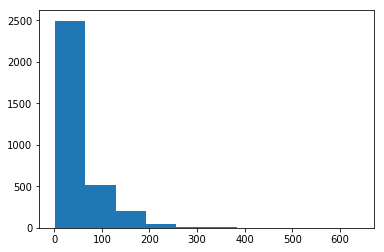

In [205]:
plt.hist(ad_df.loc[:, "height"])

In [206]:
## The high limit for acceptable values is the mean plus 2 standard deviations
LimitHi = ad_df.loc[:, "height"].mean() + 2*(ad_df.loc[:, "height"].std())
print(LimitHi)

154.56514120646216


In [207]:
#Replace outliers
TooHigh = ad_df.loc[:, "height"] > LimitHi
ad_df.loc[TooHigh, "height"] = LimitHi

(array([ 369.,  424.,  324., 1359.,  137.,  140.,  130.,   84.,   84.,
         228.]), array([  1.        ,  16.35651412,  31.71302824,  47.06954236,
         62.42605648,  77.7825706 ,  93.13908472, 108.49559884,
        123.85211297, 139.20862709, 154.56514121]), <a list of 10 Patch objects>)

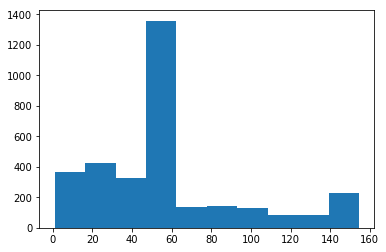

In [208]:
plt.hist(ad_df.loc[:, "height"])

In [209]:
# Coerce to numeric and impute medians for width column
ad_df.loc[:, "width"] = pd.to_numeric(ad_df.loc[:, "width"], errors='coerce')
HasNan = np.isnan(ad_df.loc[:,"width"])
ad_df.loc[HasNan, "width"] = np.nanmedian(ad_df.loc[:,"width"])

(array([4.640e+02, 1.849e+03, 3.890e+02, 2.540e+02, 3.500e+01, 1.800e+01,
        3.900e+01, 2.040e+02, 1.000e+00, 2.600e+01]),
 array([  1. ,  64.9, 128.8, 192.7, 256.6, 320.5, 384.4, 448.3, 512.2,
        576.1, 640. ]),
 <a list of 10 Patch objects>)

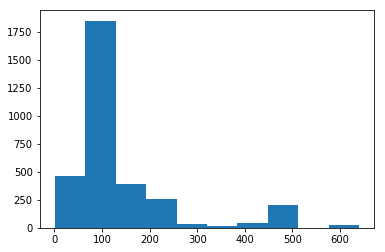

In [210]:
plt.hist(ad_df.loc[:, "width"])

In [211]:
# Coerce to numeric and impute medians for aratio column
ad_df.loc[:, "aratio"] = pd.to_numeric(ad_df.loc[:, "aratio"], errors='coerce')
HasNan = np.isnan(ad_df.loc[:,"aratio"])
ad_df.loc[HasNan, "aratio"] = np.nanmedian(ad_df.loc[:,"aratio"])

(array([2.765e+03, 4.810e+02, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+01]),
 array([1.500000e-03, 6.001350e+00, 1.200120e+01, 1.800105e+01,
        2.400090e+01, 3.000075e+01, 3.600060e+01, 4.200045e+01,
        4.800030e+01, 5.400015e+01, 6.000000e+01]),
 <a list of 10 Patch objects>)

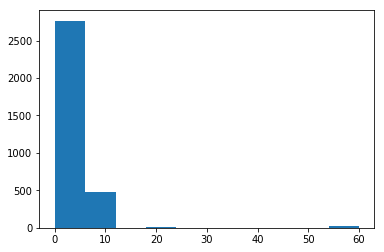

In [212]:
plt.hist(ad_df.loc[:, "aratio"])

In [213]:
## The high limit for acceptable values is the mean plus 2 standard deviations
LimitHi = ad_df.loc[:, "aratio"].mean() + 2*(ad_df.loc[:, "aratio"].std())
print(LimitHi)

13.809091493987335


In [214]:
#Replace outliers
TooHigh = ad_df.loc[:, "aratio"] > LimitHi
ad_df.loc[TooHigh, "aratio"] = LimitHi

(array([9.08e+02, 1.32e+03, 2.87e+02, 2.13e+02, 8.70e+01, 2.84e+02,
        1.21e+02, 2.50e+01, 1.00e+00, 3.30e+01]),
 array([1.50000000e-03, 1.38225915e+00, 2.76301830e+00, 4.14377745e+00,
        5.52453660e+00, 6.90529575e+00, 8.28605490e+00, 9.66681405e+00,
        1.10475732e+01, 1.24283323e+01, 1.38090915e+01]),
 <a list of 10 Patch objects>)

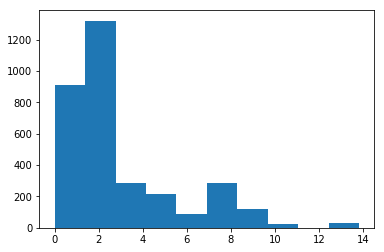

In [215]:
plt.hist(ad_df.loc[:, "aratio"])

In [216]:
# Coerce to numeric and impute medians for local column
ad_df.loc[:, "local"] = pd.to_numeric(ad_df.loc[:, "local"], errors='coerce')
HasNan = np.isnan(ad_df.loc[:,"local"])
ad_df.loc[HasNan, "local"] = np.nanmedian(ad_df.loc[:,"local"])

In [217]:
#check data type counts
ad_df.dtypes.value_counts()

int64      1554
float64       4
object        1
dtype: int64

In [218]:
ad_df.head()

,height continuous,width continuous,aratio continuous,local,url_images+buttons,url_likesbookscom,url_wwwslakecom,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,ad nonad
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad


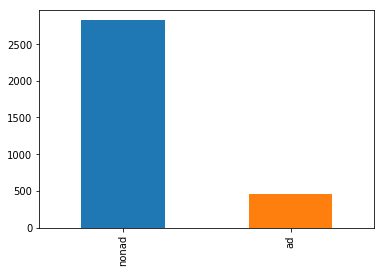

In [219]:
# plot the counts for each category
ad_df.loc[:,"ad nonad"].value_counts().plot(kind='bar')

In [220]:
#create new numeric colmns
ad_df.loc[:,"ad"] = (ad_df.loc[:,"ad nonad"] == "ad").astype(int)
ad_df.loc[:,"nonad"] = (ad_df.loc[:,"ad nonad"] == "nonad").astype(int)

In [221]:
# Remove obsolete column "ad nonad"
ad_df = ad_df.drop("ad nonad", axis=1)

### Normalization

In [222]:
#columns to apply z-normalization aka standardization
p = ad_df[['height','width','aratio']]

In [223]:
#standardization - change the variable so that it’s mean is equal to 0.0 and its standard dev is equal to 1.0
standardization_scale = StandardScaler().fit(p)

In [224]:
z = standardization_scale.transform(p)

In [225]:
hc_scaled = pd.DataFrame(z)

In [226]:
ad_df[['height','width','aratio']] = hc_scaled

In [227]:
#Drop 'nonad' column. 'ad' will be the target
ad_df = ad_df.drop("nonad", axis=1)

In [228]:
ad_df.head()

,height continuous,width continuous,aratio continuous,local,url_images+buttons,url_likesbookscom,url_wwwslakecom,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,ad
0,1.817265,-0.158911,-0.804119,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.025925,2.888693,1.967350,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.676463,0.774029,1.490390,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.055392,2.888693,1.809568,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.055392,2.888693,1.809568,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Export data

In [229]:
#dataframe to csv
ad_df.to_csv('InternetAd_Dataset.csv', index=None)

### Data Modeling

In [230]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

In [231]:
def split_dataset(data, r): # split a dataset
	N = len(data)
	X = []
	Y = []
	
	if r >= 1: 
		print ("Parameter r needs to be smaller than 1!")
		return
	elif r <= 0:
		print ("Parameter r needs to be larger than 0!")
		return

	n = int(round(N*r)) # number of elements in testing sample
	nt = N - n # number of elements in training sample
	ind = -np.ones(n,int) # indexes for testing sample
	R = np.random.randint(N) # some random index from the whole dataset
	
	for i in range(n):
		while R in ind: R = np.random.randint(N) # ensure that the random index hasn't been used before
		ind[i] = R

	ind_ = list(set(range(N)).difference(ind)) # remaining indexes	
	X = data[ind_,:-1] # training features
	XX = data[ind,:-1] # testing features
	Y = data[ind_,-1] # training targets
	YY = data[ind,-1] # testing targests
	return X, XX, Y, YY

In [232]:
r = 0.2 # ratio of test data over all data (this can be changed to any number between 0.0 and 1.0 (not inclusive)
dataset = np.genfromtxt('InternetAd_Dataset.csv', delimiter=",", skip_header=1)
X, XX, Y, YY = split_dataset(dataset, r)

In [233]:
""" CLASSIFICATION MODELS """
# Logistic regression classifier
print ('\n\n\nLogistic regression classifier\n')
C_parameter = 50. / len(X) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter




Logistic regression classifier



In [234]:
#Training the Model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, penalty=penalty_parameter, solver=solver_parameter, tol=tolerance_parameter)
clf.fit(X, Y) 
print ('coefficients:')
print (clf.coef_) # each row of this matrix corresponds to each one of the classes of the dataset
print ('intercept:')
print (clf.intercept_) # each element of this vector corresponds to each one of the classes of the dataset

# Apply the Model
print ('predictions for test set:')
print (clf.predict(XX))
print ('actual class values:')
print (YY)

coefficients:
[[0.         0.80858795 0.00123179 ... 0.         0.         0.        ]]
intercept:
[-2.2999795]
predictions for test set:
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [235]:
# Naive Bayes classifier
print ('\n\nNaive Bayes classifier\n')
nbc = GaussianNB() # default parameters are fine
nbc.fit(X, Y)
print ("predictions for test set:")
print (nbc.predict(XX))
print ('actual class values:')
print (YY)



Naive Bayes classifier

predictions for test set:
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.

In [236]:
# k Nearest Neighbors classifier
print ('\n\nK nearest neighbors classifier\n')
k = 5 # number of neighbors
distance_metric = 'euclidean'
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
knn.fit(X, Y)
print ("predictions for test set:")
print (knn.predict(XX))
print ('actual class values:')
print (YY)



K nearest neighbors classifier

predictions for test set:
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [237]:
# Support vector machine classifier
t = 0.001 # tolerance parameter
kp = 'rbf' # kernel parameter
print ('\n\nSupport Vector Machine classifier\n')
clf = SVC(kernel=kp, tol=t)
clf.fit(X, Y)
print ("predictions for test set:")
print (clf.predict(XX))
print ('actual class values:')
print (YY)
####################



Support Vector Machine classifier

predictions for test set:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [238]:
# Decision Tree classifier
print ('\n\nDecision Tree classifier\n')
clf = DecisionTreeClassifier() # default parameters are fine
clf.fit(X, Y)
print ("predictions for test set:")
print (clf.predict(XX))
print ('actual class values:')
print (YY)
####################



Decision Tree classifier

predictions for test set:
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 

In [239]:
# Random Forest classifier
estimators = 10 # number of trees parameter
mss = 2 # mininum samples split parameter
print ('\n\nRandom Forest classifier\n')
clf = RandomForestClassifier(n_estimators=estimators, min_samples_split=mss) # default parameters are fine
clf.fit(X, Y)
print ("predictions for test set:")
print (clf.predict(XX))
print ('actual class values:')
print (YY)
####################



Random Forest classifier

predictions for test set:
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 